In [1]:
#utility
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import pyecharts

#pre-processing
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline


# Data import

In [2]:
data = pd.read_csv('data.csv')
#data.tail(20)

# Feature engineering

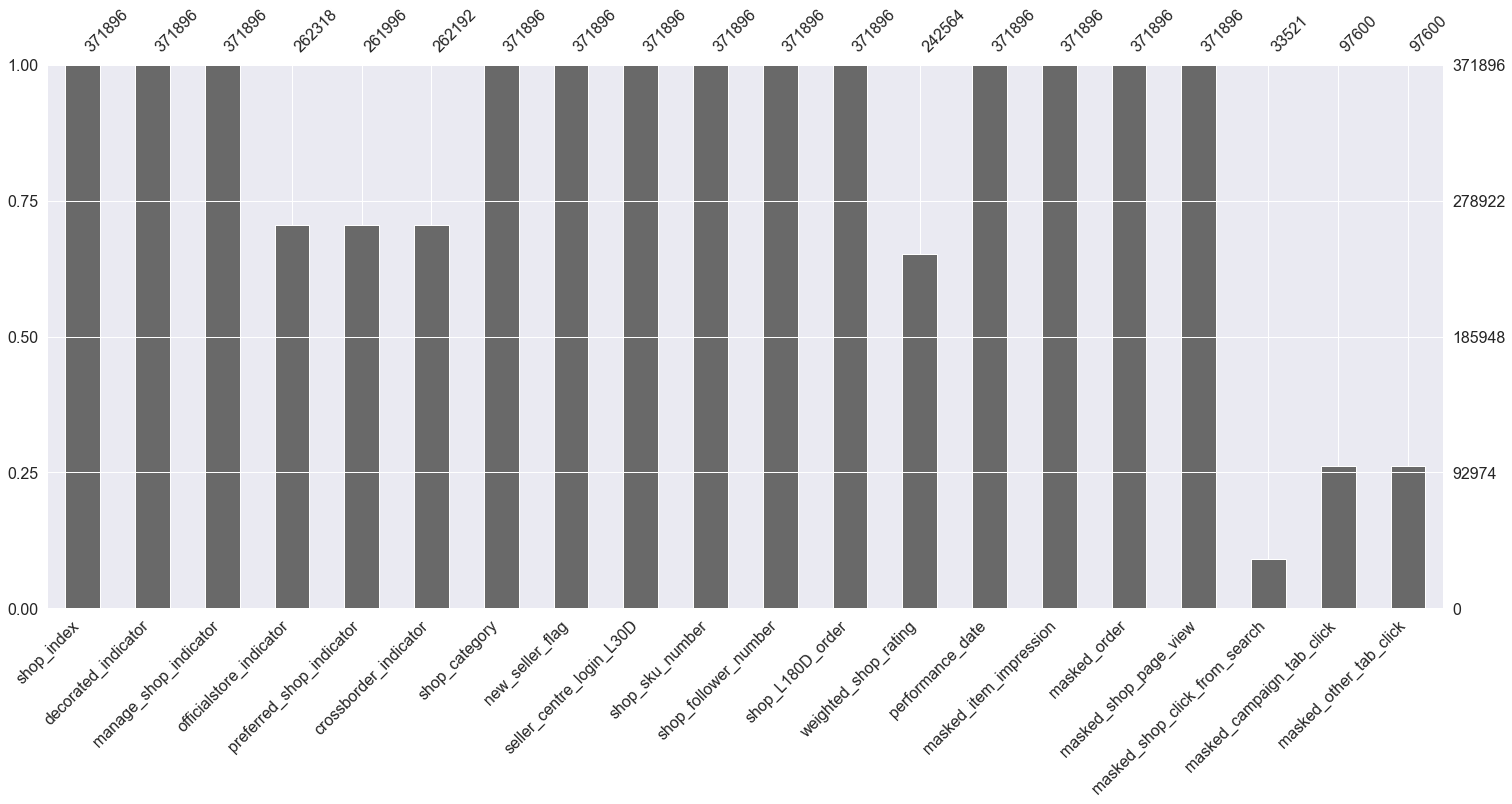

In [6]:
msno.bar(data)

In [3]:
#simple fill-null
data["manage_shop_indicator"].fillna(0,inplace=True)
data["shop_category"].fillna(np.random.randint(0,19), inplace =True)

#convert text into numeric value
data['decorated_indicator'] = np.where(data['decorated_indicator']== 'N', 0, 1)
data['new_seller_flag'] = np.where(data['new_seller_flag']== 'old_seller', 0, 1)
data['shop_category'] = np.where(data['shop_category']== 'Home & Living', int(0), 
                                 np.where(data['shop_category']== 'Hobbies & Stationery', int(1), 
                                np.where(data['shop_category']== 'Men\'s Bags & Accessories', int(2),
                                np.where(data['shop_category']== 'Toys, Games & Collectibles', int(3), 
                                np.where(data['shop_category']== 'Motors', int(4),
                                np.where(data['shop_category']== 'Makeup & Fragrances', int(5), 
                                np.where(data['shop_category']== 'Health & Personal Care', int(6), 
                                np.where(data['shop_category']== 'Men\'s Apparel', int(7), 
                                np.where(data['shop_category']== 'Women\'s Apparel', int(8), 
                                np.where(data['shop_category']== 'Babies & Kids', int(9), 
                                np.where(data['shop_category']== 'Home Appliances', int(10), 
                                np.where(data['shop_category']== 'Pet Care', int(11),
                                np.where(data['shop_category']== 'Home Entertainment', int(12), 
                                np.where(data['shop_category']== 'Mobile Accessories', int(13), 
                                np.where(data['shop_category']== 'Women\'s Bags', int(14), 
                                np.where(data['shop_category']== 'Sports & Travel', int(15), 
                                np.where(data['shop_category']== 'Women Shoes', int(16), 
                                np.where(data['shop_category']== 'Mobiles & Gadgets', int(17), 
                                np.where(data['shop_category']== 'Cameras', int(18), 
                                np.where(data['shop_category']== 'Gaming', int(19), 
                                int(20)))))))))))))))))))))

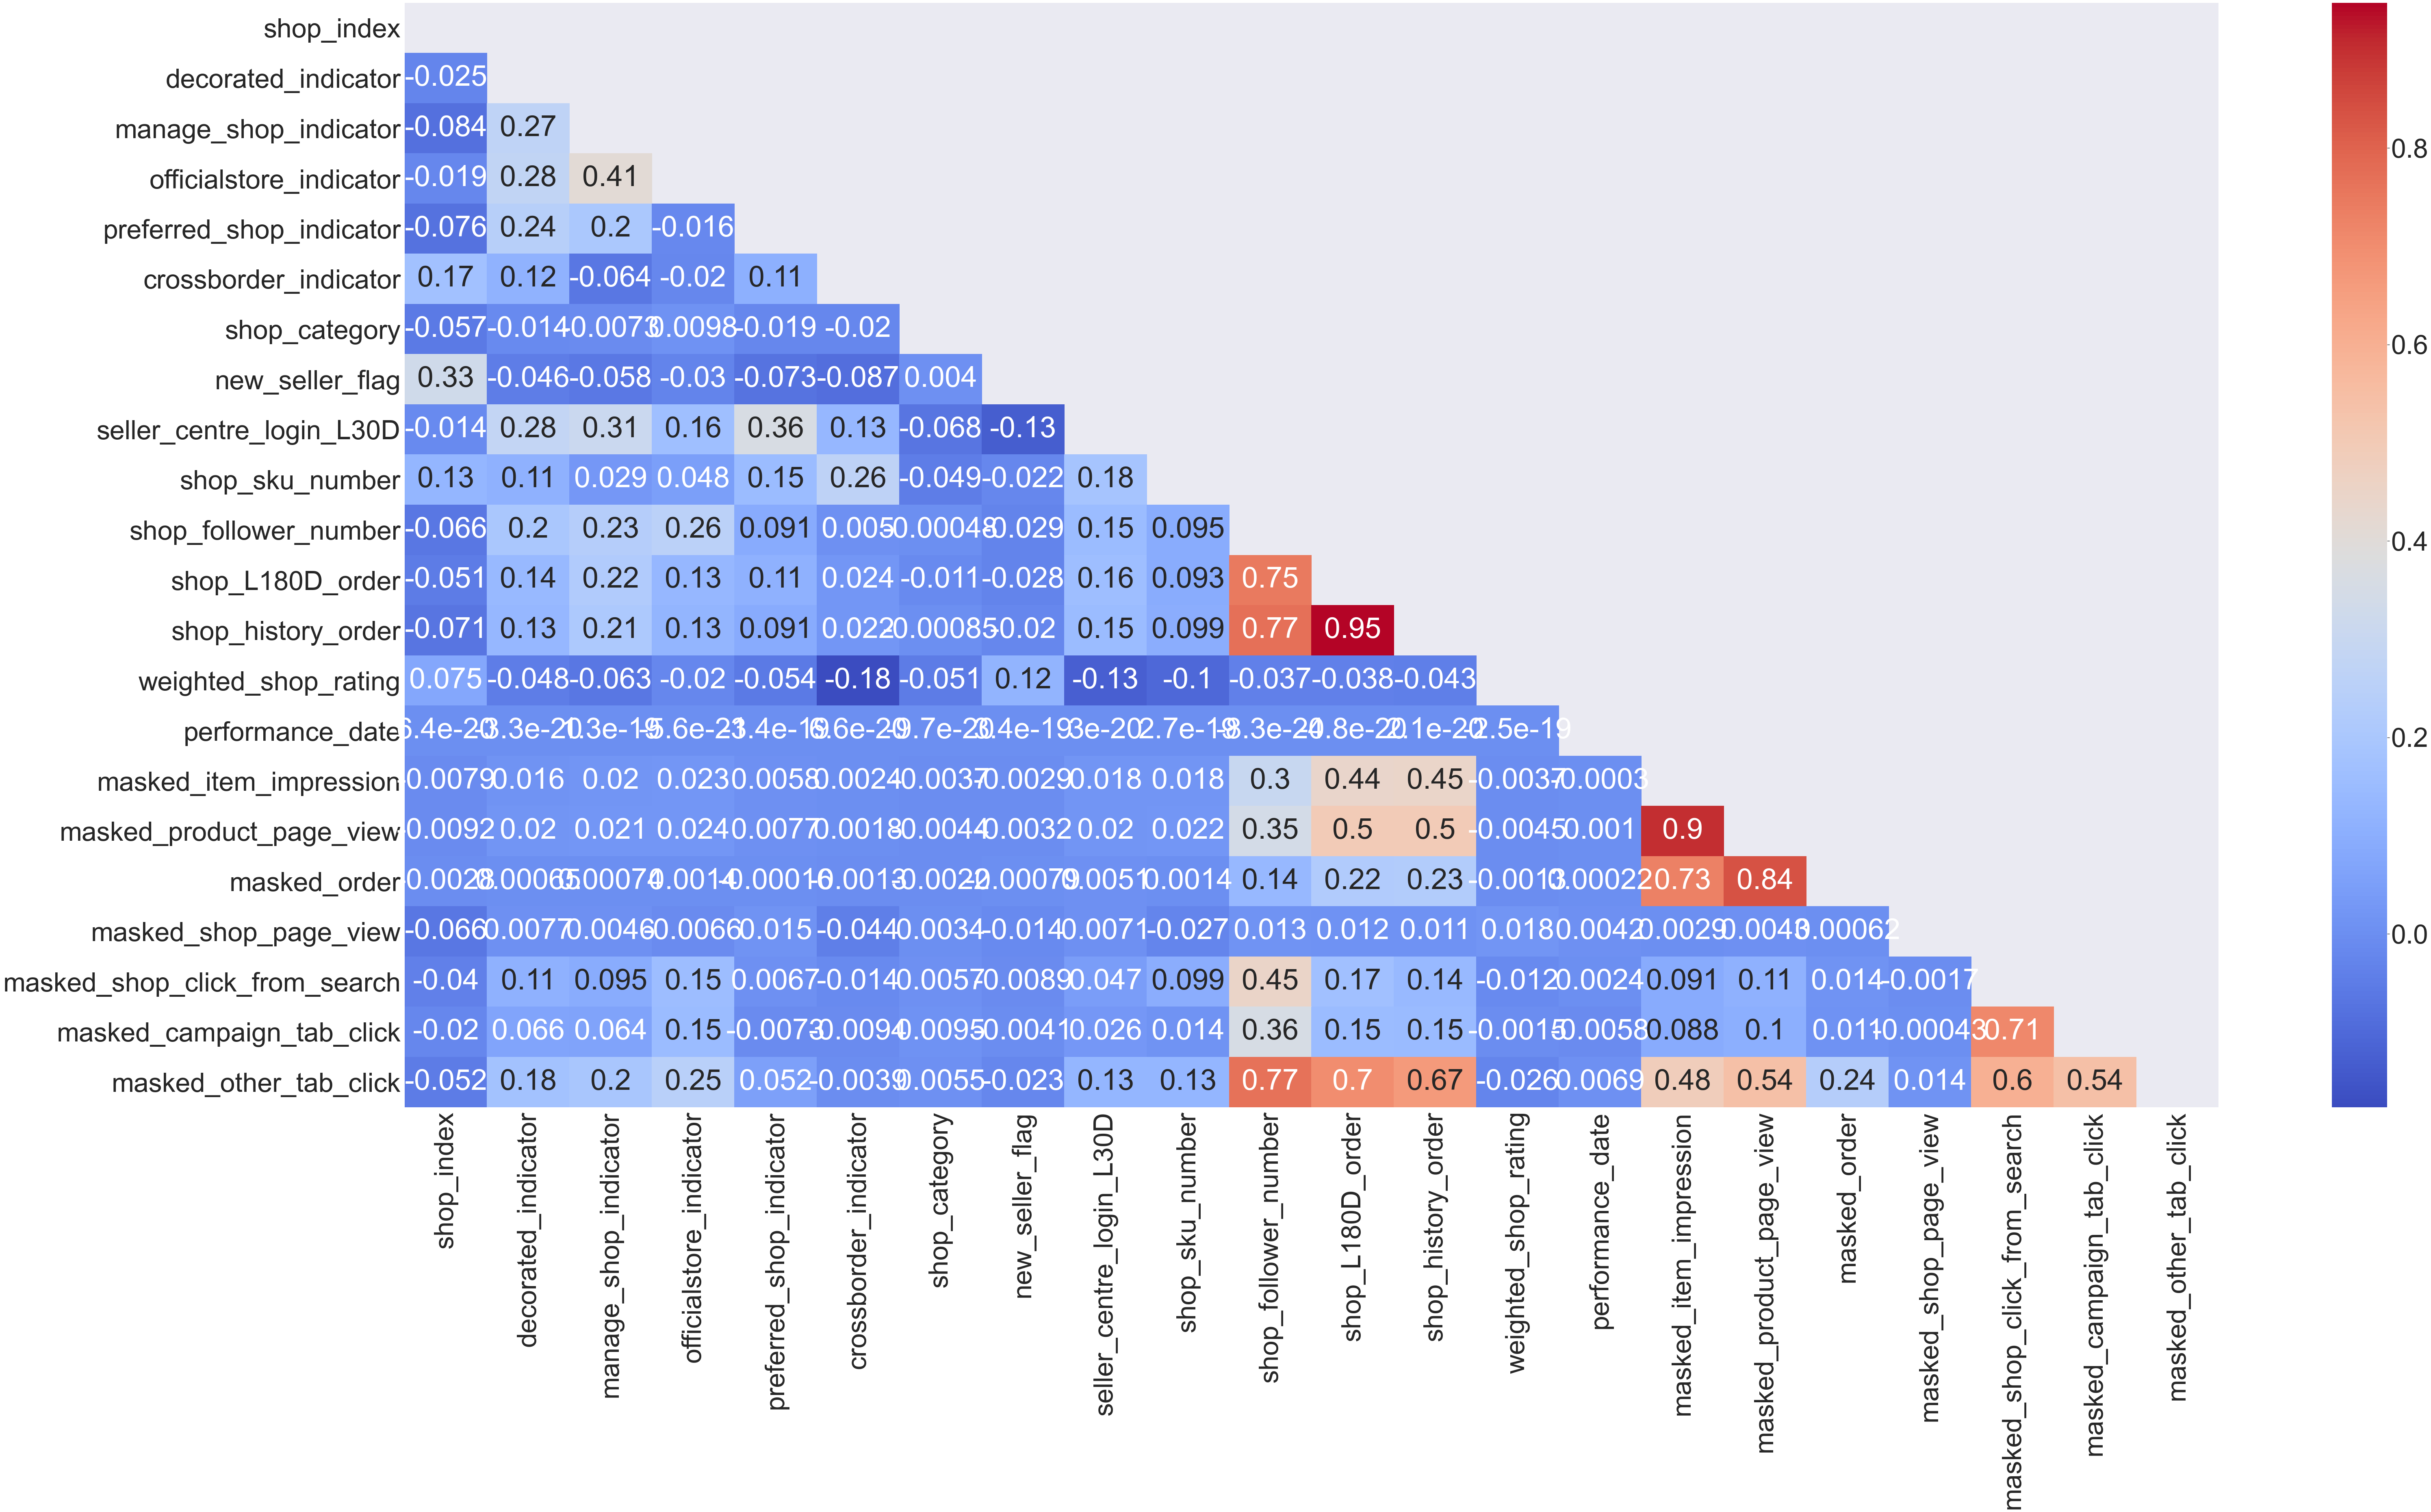

In [4]:
#Correlation Matrix
sns.set(font_scale=6)
plt.figure(figsize=(100,50))
corr = data.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=matrix)
#corr

In [5]:
#drop columns with high correlation
data = data.drop(columns=['shop_history_order', 'masked_product_page_view'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371896 entries, 0 to 371895
Data columns (total 20 columns):
shop_index                       371896 non-null int64
decorated_indicator              371896 non-null int32
manage_shop_indicator            371896 non-null float64
officialstore_indicator          262318 non-null float64
preferred_shop_indicator         261996 non-null float64
crossborder_indicator            262192 non-null float64
shop_category                    371896 non-null int32
new_seller_flag                  371896 non-null int32
seller_centre_login_L30D         371896 non-null int64
shop_sku_number                  371896 non-null int64
shop_follower_number             371896 non-null int64
shop_L180D_order                 371896 non-null int64
weighted_shop_rating             242564 non-null float64
performance_date                 371896 non-null int64
masked_item_impression           371896 non-null float64
masked_order                     371896 non-null flo

# Dataset splitting

In [8]:
whitelist = data[data['decorated_indicator'] == 1]
non_whitelist = data[data['decorated_indicator'] == 0]

## whitelist data

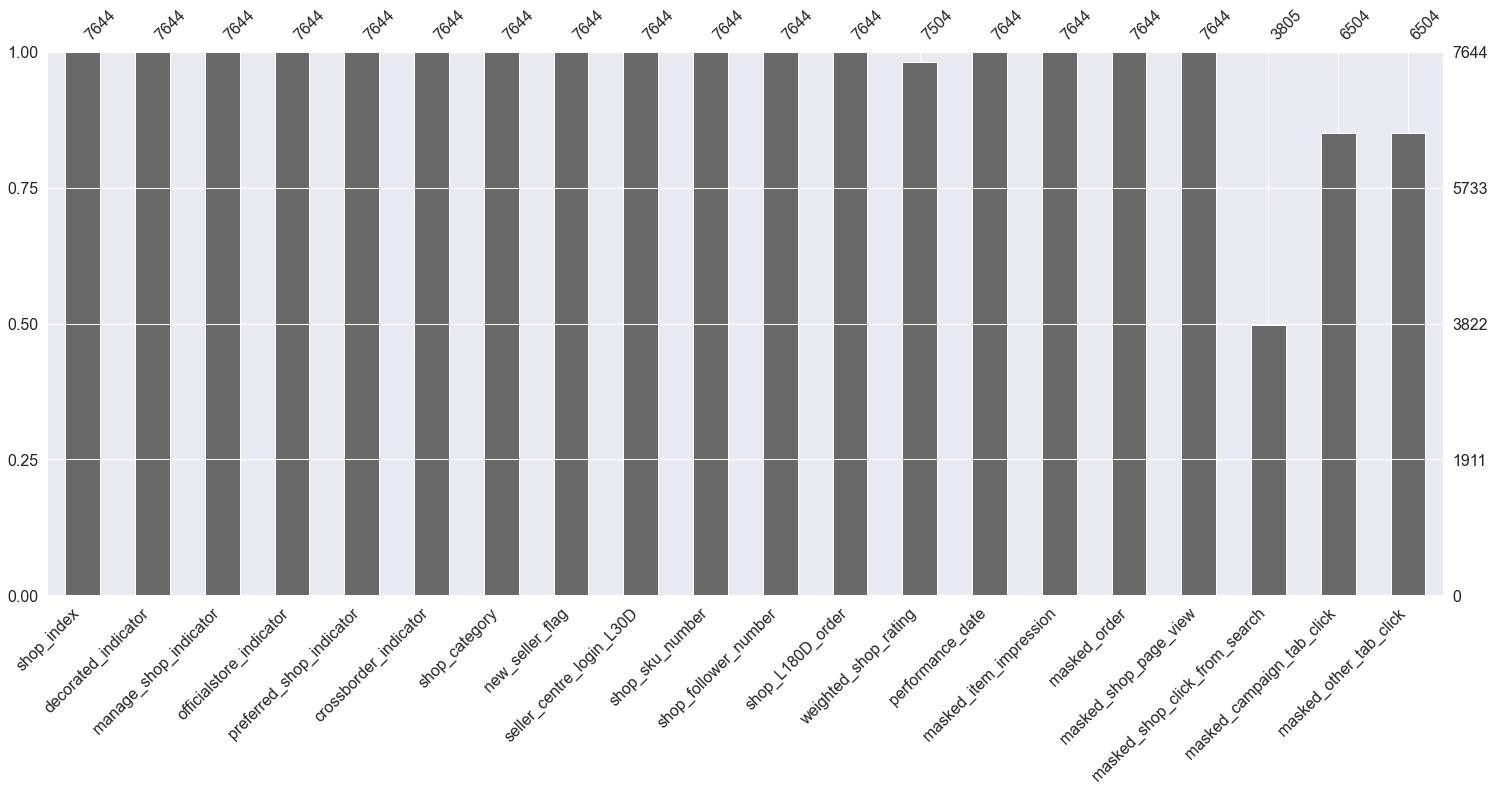

In [9]:
msno.bar(whitelist)

In [ ]:
# for variables with few missing values, drop them (as the no. of missing values is vary small)
whitelist.dropna(subset=["weighted_shop_rating"],inplace=True)

In [ ]:
#K-NN null value fill-up
imputer = KNNImputer(n_neighbors=19, weights='uniform', metric='nan_euclidean')
imputer.fit(whitelist.iloc[:,1:])
whitelist_filled = imputer.transform(whitelist.iloc[:,1:])

#label the filled values with column name and add shop_id back
whitelist_filled=pd.DataFrame(whitelist_filled,columns=list(whitelist.columns)[1:])
whitelist_filled['shop_index']=whitelist['shop_index'].values

#export filled whitelist data
whitelist_filled.to_csv('whitelist_filled.csv')

# non-whitelist data

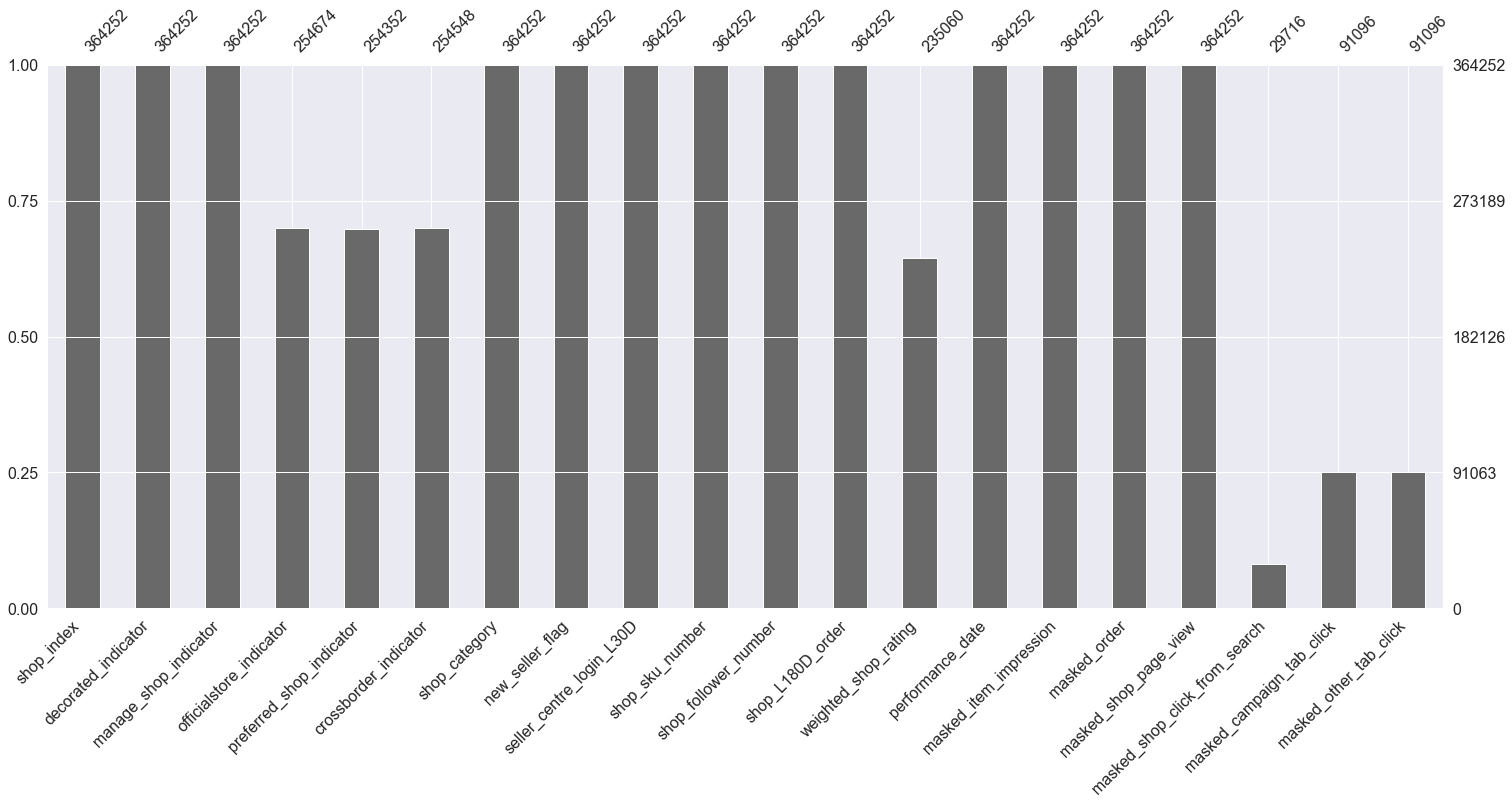

In [10]:
msno.bar(non_whitelist)

In [ ]:
#fill for 3 indicator columns
non_whitelist_test=non_whitelist.copy(deep=False)
non_whitelist_test = non_whitelist_test.drop(columns=['masked_shop_click_from_search','masked_campaign_tab_click', 'masked_other_tab_click'])
non_whitelist_test_shop=non_whitelist_test.groupby('shop_index').mean() #construct a shop_id >> indicator pair

non_whitelist_test_shop["officialstore_indicator"].fillna(np.random.randint(0,1), inplace =True)
non_whitelist_test_shop["preferred_shop_indicator"].fillna(np.random.randint(0,1), inplace =True)
non_whitelist_test_shop["crossborder_indicator"].fillna(np.random.randint(0,1), inplace =True)

#fill NaN according to value assigned in non_whitelist_test_shop
for index, row in non_whitelist[non_whitelist['officialstore_indicator'].isnull()].iterrows():
    non_whitelist.loc[index,'officialstore_indicator']=non_whitelist_test_shop['officialstore_indicator'][row['shop_index']]

for index, row in non_whitelist[non_whitelist['preferred_shop_indicator'].isnull()].iterrows():
    non_whitelist.loc[index,'preferred_shop_indicator']=non_whitelist_test_shop['preferred_shop_indicator'][row['shop_index']]

for index, row in non_whitelist[non_whitelist['crossborder_indicator'].isnull()].iterrows():
    non_whitelist.loc[index,'crossborder_indicator']=non_whitelist_test_shop['crossborder_indicator'][row['shop_index']]


In [ ]:
#K-NN null value fill-up
imputer = KNNImputer(n_neighbors=19, weights='uniform', metric='nan_euclidean')
imputer.fit(non_whitelist.iloc[:,1:]) #exclude shop_id
non_whitelist_filled = imputer.transform(non_whitelist.iloc[:,1:]) #result is array format

#transform result array into df
non_whitelist_filled=pd.DataFrame(non_whitelist_filled,columns=list(non_whitelist.columns)[1:])
non_whitelist_filled['shop_index']=non_whitelist['shop_index'].values

#export into csv
non_whitelist_filled.to_csv('non_whitelist_filled.csv')